# Tutorial: Beat Detection & Tempo Analysis with librosa

This tutorial teaches you how to detect beats and analyze tempo in audio recordings. Understanding a song's rhythmic structure computationally is essential for music information retrieval, DJ software, automatic playlist generation, and music production.

**What you'll learn:**
- How to detect beats in audio files
- How to estimate tempo (BPM)
- How to visualize rhythm with onset envelopes and tempograms
- How to create click tracks for verification

## Step 1: Setup

Install and import the required libraries.

In [ ]:
# Install libraries
!pip install librosa soundfile

# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd

print("Libraries loaded successfully!")

## Step 2: Load Audio and Detect Tempo

librosa's `beat_track()` function simultaneously estimates tempo (BPM) and identifies beat locations.

In [ ]:
# Load audio (choice examples: 'trumpet', 'nutcracker', 'choice', 'brahms')
y, sr = librosa.load(librosa.ex('choice'))

# Detect tempo and beats
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

print(f"Estimated tempo: {tempo[0]:.1f} BPM")
print(f"Number of beats detected: {len(beats)}")

# Convert beat frames to time (in seconds)
beat_times = librosa.frames_to_time(beats, sr=sr)
print(f"First 5 beat times (seconds): {beat_times[:5].round(3)}")

# Listen to the audio
Audio(y, rate=sr)

## Step 3: Visualize Beats on the Waveform

Let's see exactly where the detected beats fall on the audio waveform.

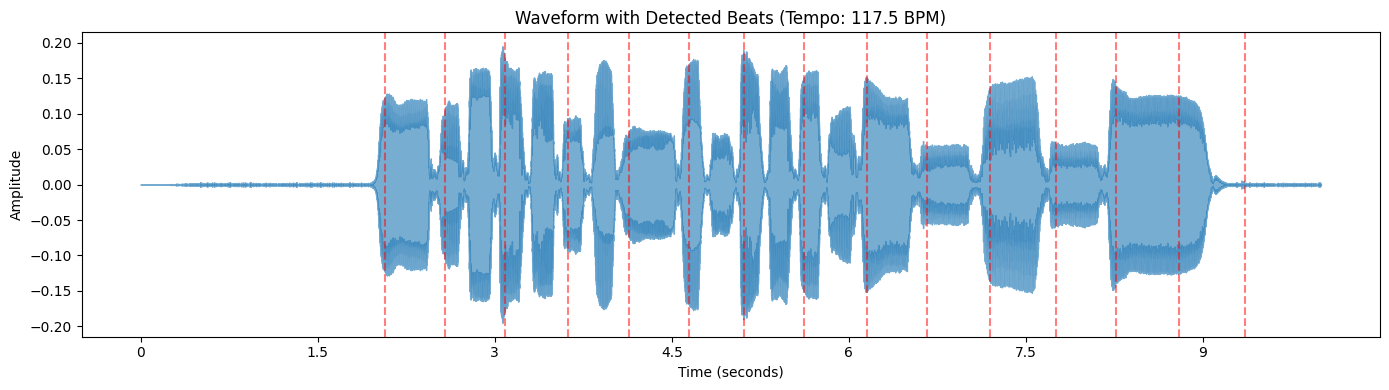

In [1]:
# Create the plot
plt.figure(figsize=(14, 4))

# Plot the waveform
librosa.display.waveshow(y, sr=sr, alpha=0.6)

# Mark each beat with a vertical red line
for beat_time in beat_times:
    plt.axvline(x=beat_time, color='red', alpha=0.5, linestyle='--')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Waveform with Detected Beats (Tempo: {tempo[0]:.1f} BPM)')
plt.tight_layout()
plt.show()

## Step 4: Create a Click Track

A click track adds audible clicks at each detected beat. This lets you hear whether the detection matches your perception of the pulse.

In [ ]:
# Generate click sounds at each beat time
clicks = librosa.clicks(times=beat_times, sr=sr, length=len(y))

# Mix the clicks with the original audio
# Reduce click volume to 0.3 so it doesn't overpower the music
y_with_clicks = y + 0.3 * clicks

# Listen to the result
print("Listen to hear clicks on each detected beat:")
Audio(y_with_clicks, rate=sr)

**How to evaluate:** Do the clicks align with where you perceive the beat? If not, the tempo might be doubled/halved, or the rhythm might be complex.

## Step 5: Analyze the Onset Strength Envelope

The **onset strength envelope** shows how much musical energy changes at each moment. Peaks often correspond to beats—it's the foundation of beat detection.

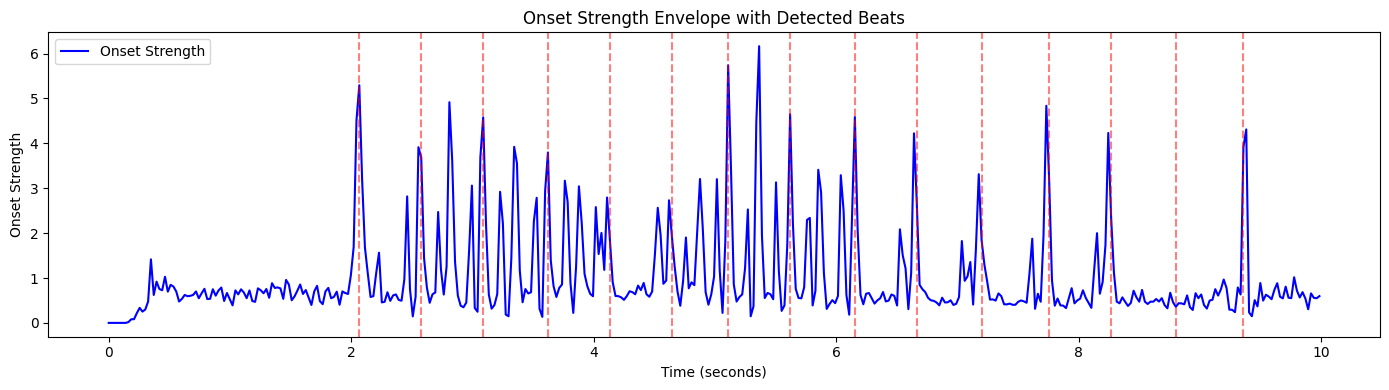

In [1]:
# Compute the onset strength envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Create time axis for plotting
times = librosa.times_like(onset_env, sr=sr)

# Plot the onset strength envelope with beats
plt.figure(figsize=(14, 4))
plt.plot(times, onset_env, label='Onset Strength', color='blue')

# Mark the beat locations
for beat_time in beat_times:
    plt.axvline(x=beat_time, color='red', alpha=0.5, linestyle='--')

plt.xlabel('Time (seconds)')
plt.ylabel('Onset Strength')
plt.title('Onset Strength Envelope with Detected Beats')
plt.legend()
plt.tight_layout()
plt.show()

**Reading the onset envelope:**
- Peaks = Strong onsets (attacks, loud notes)
- Valleys = Sustained notes or silence
- Beat lines should align with major peaks

## Step 6: Create a Tempogram

A **tempogram** shows how tempo varies over time. The x-axis is time, y-axis is tempo (BPM), and brightness indicates tempo strength at each moment.

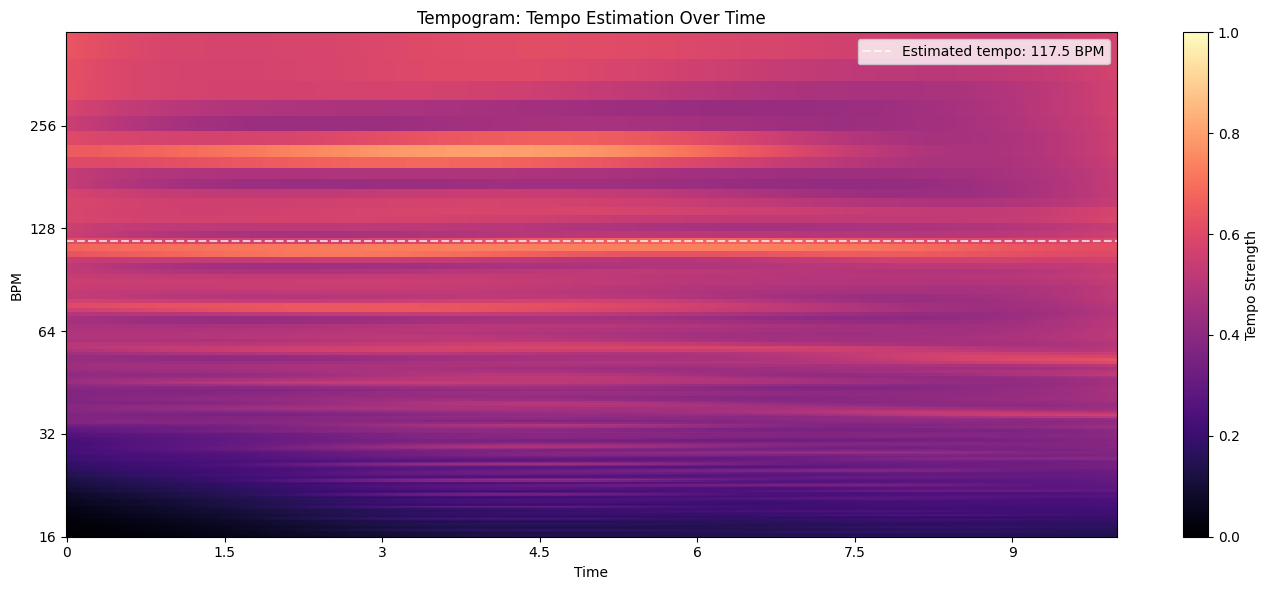

In [1]:
# Compute the tempogram
tempogram = librosa.feature.tempogram(y=y, sr=sr)

# Plot the tempogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(tempogram, sr=sr, x_axis='time', y_axis='tempo', cmap='magma')
plt.colorbar(label='Tempo Strength')
plt.axhline(y=tempo[0], color='white', linestyle='--', alpha=0.7, 
            label=f'Estimated tempo: {tempo[0]:.1f} BPM')
plt.title('Tempogram: Tempo Estimation Over Time')
plt.legend()
plt.tight_layout()
plt.show()

**Reading a tempogram:**
- Bright horizontal lines = Consistent tempo
- Multiple lines = Tempo harmonics (double/half time)
- Wandering brightness = Tempo changes or rubato

## Step 7: Complete Beat Analysis Function

Here's a reusable function that performs comprehensive beat analysis and exports the results.

In [ ]:
def analyze_beats(y, sr):
    """Comprehensive beat analysis function."""
    
    # Detect tempo and beats
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
    beat_times = librosa.frames_to_time(beats, sr=sr)
    
    # Calculate beat intervals (time between beats)
    if len(beat_times) > 1:
        beat_intervals = np.diff(beat_times)
        avg_interval = np.mean(beat_intervals)
        interval_std = np.std(beat_intervals)
    else:
        beat_intervals = []
        avg_interval = 0
        interval_std = 0
    
    # Create summary
    summary = {
        'Estimated Tempo (BPM)': tempo[0],
        'Total Beats': len(beats),
        'Duration (seconds)': len(y) / sr,
        'Average Beat Interval (s)': avg_interval,
        'Interval Std Dev (s)': interval_std,
        'Tempo Consistency (%)': 100 * (1 - interval_std / avg_interval) if avg_interval > 0 else 0
    }
    
    # Create DataFrame of beat times
    beats_df = pd.DataFrame({
        'Beat Number': range(1, len(beat_times) + 1),
        'Time (seconds)': beat_times.round(3)
    })
    
    return summary, beats_df

# Run the analysis
summary, beats_df = analyze_beats(y, sr)

# Print summary
print("=== Beat Analysis Summary ===")
for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

# Show first 10 beats
print("\n=== First 10 Beats ===")
print(beats_df.head(10))

## Step 8: Export Beat Times

Save the detected beat times to a CSV file for use in other applications.

In [ ]:
# Export to CSV
beats_df.to_csv('detected_beats.csv', index=False)
print("Beat times saved to 'detected_beats.csv'")

# Download the file (in Colab)
from google.colab import files
files.download('detected_beats.csv')

## Step 9: Adjust Beat Detection Parameters

Fine-tune beat detection with these parameters:
- **start_bpm**: Initial tempo estimate (default: 120)
- **tightness**: How strictly beats follow tempo (higher = stricter)

In [ ]:
# Example: Adjust for faster music
tempo_fast, beats_fast = librosa.beat.beat_track(
    y=y, 
    sr=sr,
    start_bpm=140,    # Higher initial tempo
    tightness=200     # More flexible (default is 100)
)

print(f"With start_bpm=140: {tempo_fast[0]:.1f} BPM, {len(beats_fast)} beats")

# Compare with default
tempo_default, beats_default = librosa.beat.beat_track(y=y, sr=sr)
print(f"Default settings:   {tempo_default[0]:.1f} BPM, {len(beats_default)} beats")

## Step 10: Upload and Analyze Your Own Audio

Try the analysis on your own audio file!

In [ ]:
# Upload your own file
from google.colab import files

uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    y_custom, sr_custom = librosa.load(filename)
    
    print(f"\nLoaded: {filename}")
    print(f"Duration: {len(y_custom) / sr_custom:.2f} seconds")
    
    # Analyze
    summary_custom, beats_df_custom = analyze_beats(y_custom, sr_custom)
    
    print("\n=== Analysis Results ===")
    for key, value in summary_custom.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
    
    # Create click track
    beat_times_custom = librosa.frames_to_time(
        librosa.beat.beat_track(y=y_custom, sr=sr_custom)[1], 
        sr=sr_custom
    )
    clicks_custom = librosa.clicks(times=beat_times_custom, sr=sr_custom, length=len(y_custom))
    y_with_clicks_custom = y_custom + 0.3 * clicks_custom
    
    print("\nListen with click track:")
    Audio(y_with_clicks_custom, rate=sr_custom)

## Practice Exercises

1. **Compare different librosa examples**: Try 'nutcracker', 'brahms', and 'trumpet'
2. **Test edge cases**: Find audio with rubato or complex rhythms
3. **Create a pure metronome**: Generate only clicks at the detected tempo
4. **Analyze a song you know**: Upload music where you know the BPM and compare

In [ ]:
# Practice space - try the exercises here!

# Exercise 1: Load different examples
# y_nutcracker, sr_nutcracker = librosa.load(librosa.ex('nutcracker'))

# Exercise 3: Create a pure metronome at detected tempo
# duration = 10  # seconds
# metronome_sr = 22050
# metronome_times = np.arange(0, duration, 60/tempo[0])  # beats at detected tempo
# pure_clicks = librosa.clicks(times=metronome_times, sr=metronome_sr)
# Audio(pure_clicks, rate=metronome_sr)

## Key Concepts Summary

1. **Beat tracking** finds rhythmic pulse using onset strength patterns
2. **Tempo** is measured in beats per minute (BPM)
3. **Click tracks** help verify beat detection accuracy
4. **Onset envelopes** show musical energy changes over time
5. **Tempograms** reveal tempo consistency and variations

---

**Next tutorial**: Learn about pitch and frequency analysis with librosa!